# Linear Discriminant Analysis
First we start with a simplified LDA classfifier to gain intuition.

In [2]:
import pandas as pd
from nlpia.data.loaders import get_data
pd.options.display.width = 120

sms = get_data('sms-spam')
index = ['sms{}{}'.format(i, '!'*j) for (i, j) in zip(range(len(sms)), sms.spam)]
index[:10]

INFO:nlpia.futil:Reading CSV with `read_csv(*('c:\\Users\\lived\\.conda\\envs\\nlpia1\\lib\\site-packages\\nlpia\\data\\sms-spam.csv',), **{'nrows': None, 'low_memory': False})`...


['sms0',
 'sms1',
 'sms2!',
 'sms3',
 'sms4',
 'sms5!',
 'sms6',
 'sms7',
 'sms8!',
 'sms9!']

Here we create indexes by prepending '!' if the message is a spam.

In [4]:
sms

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
4832,1,This is the 2nd time we have tried 2 contact u...
4833,0,Will ü b going to esplanade fr home?
4834,0,"Pity, * was in mood for that. So...any other s..."
4835,0,The guy did some bitching but I acted like i'd...


In [6]:
sms = pd.DataFrame(sms.values, columns=sms.columns, index=index)
sms

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
sms4832!,1,This is the 2nd time we have tried 2 contact u...
sms4833,0,Will ü b going to esplanade fr home?
sms4834,0,"Pity, * was in mood for that. So...any other s..."
sms4835,0,The guy did some bitching but I acted like i'd...


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf_model.fit_transform(raw_documents=sms.text).toarray()

print('TF-IDF shape:', tfidf_docs.shape)
print('Spam sum:', sms.spam.sum())

TF-IDF shape: (4837, 9232)
Spam sum: 638


Naive Bayes does not work well when the vocabulary size is much larger than the labeled sample in the dataset. For this, we need to use the LDA algorithm.

In [10]:
mask = sms.spam.astype(bool).values
print(mask)

[False False  True ... False False False]


In [11]:
tfidf_docs[mask]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.17598105, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.26091803, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08705223, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.08933439, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [12]:
tfidf_docs[~mask]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
spam_centroid = tfidf_docs[mask].mean(axis=0)
ham_centroid = tfidf_docs[~mask].mean(axis=0)

spamminess_score = tfidf_docs.dot(spam_centroid - ham_centroid)
print(spamminess_score.round(2))

[-0.01 -0.02  0.04 ... -0.01 -0.    0.  ]


In [15]:
from sklearn.preprocessing import MinMaxScaler
sms['lda_score'] = MinMaxScaler().fit_transform(spamminess_score.reshape(-1, 1))
sms['lda_predict'] = (sms.lda_score > 0.5).astype(int)
sms['spam lda_predict lda_score'.split()].round(2).head(6)

,spam,lda_predict,lda_score
sms0,0,0,0.23
sms1,0,0,0.18
sms2!,1,1,0.72
sms3,0,0,0.18
sms4,0,0,0.29
sms5!,1,1,0.55


In [18]:
(1. - (sms.spam - sms.lda_predict).abs().sum() / len(sms))

0.9774653710977879

We've got a pretty high accuracy with a simple LDA classifier.

In [20]:
from pugnlp.stats import Confusion
Confusion(sms['spam lda_predict'.split()])

c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\pugnlp\stats.py:427: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  index = pd.Index(np.concatenate([df[columns[0]], df[columns[1]]])).unique()
c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\pugnlp\stats.py:447: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  setattr(self, '_colnums', np.arange(0, self._num_classes))
c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\pugnlp\stats.py:488: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  setattr(self, '_colnums', np.arange(0, self._num_classes))
c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\pugnlp\stats.py:504: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.

lda_predict,0,1
spam,,
0,4135,64
1,45,593


The false positives and false negatives are relatively low. We can adjust the classification threshold if they are out of balance.

# Latent semantic analysis

In [1]:
from nlpia.book.examples.ch04_catdog_lsa_3x6x16 import word_topic_vectors

c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\pugnlp\constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
INFO:nlpia.constants:Starting logger in nlpia.constants...
INFO:nlpia.loaders:No BIGDATA index found in c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\nlpia\data\bigdata_info.csv so copy c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\nlpia\data\bigdata_info.latest.csv to c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\nlpia\data\bigdata_info.csv if you want to "freeze" it.
INFO:nlpia.futil:Reading CSV with `read_csv(*('c:\\Users\\lived\\.conda\\envs\\nlpia1\\lib\\site-packages\\nlpia\\data\\mavis-batey-greetings.csv',), **{'low_memory': False})`...
INFO:nlpia.futil:Reading CSV with `read_csv(*('c:\\Users\\lived\\.conda\\envs\\nlpia1\\lib\\site-packages\\nlpia\\data\\sms-spam.csv',), *

In [2]:
word_topic_vectors.T.round(1)

,cat,dog,apple,lion,nyc,love
top0,-0.6,-0.4,0.5,-0.3,0.4,-0.1
top1,-0.1,-0.3,-0.4,-0.1,0.1,0.8
top2,-0.3,0.8,-0.1,-0.5,0.0,0.1


This is what the documents would look like if it were vectorized by SVD. SVD is able to generate topics and assign scores for each term. While it does not understand "cityness", it is able to group "apple", "nyc" into topic0, which kinda represents "cityness"

## Single value decomposition

In [3]:
from nlpia.book.examples.ch04_catdog_lsa_sorted import lsa_models, prettify_tdm
bow_svd, tfidf_svd = lsa_models()
prettify_tdm(**bow_svd)

c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\nlpia\futil.py:421: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  lines = np.empty(dtype=object, shape=nrows)
100%|██████████| 263/263 [00:00<?, ?it/s]


,cat,dog,apple,lion,nyc,love,text
0,,,1,,1,,NYC is the Big Apple.
1,,,1,,1,,NYC is known as the Big Apple.
2,,,,,1,1,I love NYC!
3,,,1,,1,,I wore a hat to the Big Apple party in NYC.
4,,,1,,1,,Come to NYC. See the Big Apple!
5,,,1,,,,Manhattan is called the Big Apple.
6,1,,,,,,New York is a big city for a small cat.
7,1,,,1,,,"The lion, a big cat, is the king of the jungle."
8,1,,,,,1,I love my pet cat.
9,,,,,1,1,I love New York City (NYC).


This is called the *document-term* matrix. Each row is a document, and each column tells you how many times the term appears in the document.

In [4]:
tdm = bow_svd['tdm']
tdm

,0,1,2,3,4,5,6,7,8,9,10
cat,0,0,0,0,0,0,1,1,1,0,1
dog,0,0,0,0,0,0,0,0,0,0,1
apple,1,1,0,1,1,1,0,0,0,0,0
lion,0,0,0,0,0,0,0,1,0,0,0
nyc,1,1,1,1,1,0,0,0,0,1,0
love,0,0,1,0,0,0,0,0,1,1,0


This is the transpose of the *document-term matrix*, called the *term-document matrix* (TDM). SVD accepts TDM. In short, TDM is able to group the related terms together into topics.

SVD breaks a matrix down into 3 matrices.
$$W_{m \times n} = U_{m \times p} S_{p \times p} V_{p \times n}^T$$

In [6]:
import numpy as np
U, s, Vt = np.linalg.svd(tdm)

import pandas as pd
pd.DataFrame(U, index=tdm.index).round(2)

,0,1,2,3,4,5
cat,-0.04,0.83,-0.38,-0.00,0.11,-0.38
dog,-0.00,0.21,-0.18,-0.71,-0.39,0.52
apple,-0.62,-0.21,-0.51,0.00,0.49,0.27
lion,-0.00,0.21,-0.18,0.71,-0.39,0.52
nyc,-0.75,0.00,0.24,-0.00,-0.52,-0.32
love,-0.22,0.42,0.69,0.00,0.41,0.37


In [12]:
print(s.round(1))
S = np.zeros((len(U), len(Vt)))
pd.np.fill_diagonal(S, s)
pd.DataFrame(S).round(1)

[3.1 2.2 1.8 1.  0.8 0.5]


c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until


,0,1,2,3,4,5,6,7,8,9,10
0,3.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


In [9]:
pd.DataFrame(Vt).round(2)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.44,-0.44,-0.31,-0.44,-0.44,-0.20,-0.01,-0.01,-0.08,-0.31,-0.01
1,-0.09,-0.09,0.19,-0.09,-0.09,-0.09,0.37,0.47,0.56,0.19,0.47
2,-0.16,-0.16,0.52,-0.16,-0.16,-0.29,-0.22,-0.32,0.17,0.52,-0.32
3,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.71,0.00,-0.00,-0.71
4,-0.04,-0.04,-0.14,-0.04,-0.04,0.58,0.13,-0.33,0.62,-0.14,-0.33
5,-0.09,-0.09,0.10,-0.09,-0.09,0.51,-0.73,0.27,-0.01,0.10,0.27
6,-0.57,0.21,0.11,0.33,-0.31,0.34,0.34,-0.00,-0.34,0.23,0.00
7,-0.32,0.47,0.25,-0.63,0.41,0.07,0.07,0.00,-0.07,-0.18,0.00
8,-0.50,0.29,-0.20,0.41,0.16,-0.37,-0.37,-0.00,0.37,-0.17,0.00
9,-0.15,-0.15,-0.59,-0.15,0.42,0.04,0.04,-0.00,-0.04,0.63,-0.00


# Principle component analysis

INFO:nlpia.futil:Reading CSV with `read_csv(*('c:\\Users\\lived\\.conda\\envs\\nlpia1\\lib\\site-packages\\nlpia\\data\\pointcloud.csv.gz',), **{'nrows': None, 'low_memory': False})`...


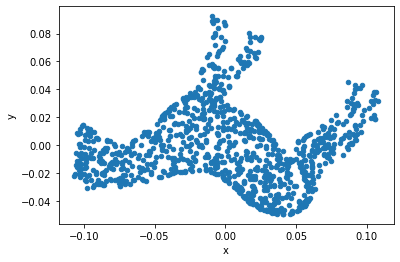

In [13]:
import pandas as pd
from sklearn.decomposition import PCA

import seaborn
from matplotlib import pyplot as plt
from nlpia.data.loaders import get_data

df = get_data('pointcloud').sample(1000)
pca = PCA(n_components=2)
df2d = pd.DataFrame(pca.fit_transform(df), columns='x y'.split())
df2d.plot(kind='scatter', x='x', y='y')
plt.show()

If PCA is able to retain the horse shape in 2D, it should be able to retain as much information as possible for natural language vectors.

## Spam detection using PCA

In [1]:
import pandas as pd

from nlpia.data.loaders import get_data
sms = get_data('sms-spam')
sms

c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\pugnlp\constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
INFO:nlpia.constants:Starting logger in nlpia.constants...
INFO:nlpia.loaders:No BIGDATA index found in c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\nlpia\data\bigdata_info.csv so copy c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\nlpia\data\bigdata_info.latest.csv to c:\Users\lived\.conda\envs\nlpia1\lib\site-packages\nlpia\data\bigdata_info.csv if you want to "freeze" it.
INFO:nlpia.futil:Reading CSV with `read_csv(*('c:\\Users\\lived\\.conda\\envs\\nlpia1\\lib\\site-packages\\nlpia\\data\\mavis-batey-greetings.csv',), **{'low_memory': False})`...
INFO:nlpia.futil:Reading CSV with `read_csv(*('c:\\Users\\lived\\.conda\\envs\\nlpia1\\lib\\site-packages\\nlpia\\data\\sms-spam.csv',), *

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
4832,1,This is the 2nd time we have tried 2 contact u...
4833,0,Will ü b going to esplanade fr home?
4834,0,"Pity, * was in mood for that. So...any other s..."
4835,0,The guy did some bitching but I acted like i'd...


In [2]:
index = ['sms{}{}'.format(i, '!'*j) for (i, j) in zip(range(len(sms)), sms.spam)]
sms.index = index
sms.head(5)

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."


Calculate TF-IDF vectors.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=sms.text).toarray()

tfidf_docs = pd.DataFrame(tfidf_docs)
tfidf_docs = tfidf_docs - tfidf_docs.mean()
print('TF-IDF vectors:', tfidf_docs.shape)
print('Number of spam messages:', sms.spam.sum())
print('Percentage of spam messages:', (sms.spam.sum() / len(sms)).round(2))

TF-IDF vectors: (4837, 9232)
Number of spam messages: 638
Percentage of spam messages: 0.13


We have an imbalanced dataset, whether one class (spam) is significantly less than the other. PCA can fix this by reducing the input data to generalized dimensions.

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=16)
pca = pca.fit(tfidf_docs)

pca_topic_vectors = pca.transform(tfidf_docs)
columns = ['topic{}'.format(i) for i in range(pca.n_components)]
pca_topic_vectors = pd.DataFrame(pca_topic_vectors, columns=columns, index=index)
pca_topic_vectors.round(3).head(6)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,0.039,-0.065,0.012,-0.082,0.009,-0.008,0.005,-0.037,-0.009,-0.036
sms1,0.404,-0.094,-0.077,0.051,0.100,0.047,0.023,0.066,0.024,-0.023,-0.003,0.035,0.042,-0.020,0.037,0.045
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,-0.000,-0.001,-0.057,0.052,0.125,0.024,0.022,-0.019,-0.051,-0.052
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,-0.165,-0.073,0.063,-0.106,0.021,0.023,0.069,-0.057,0.015,0.061
sms4,0.002,0.031,0.038,0.034,-0.075,-0.092,-0.044,0.061,-0.045,0.029,0.027,-0.006,0.033,0.028,-0.091,0.023
sms5!,-0.016,0.059,0.014,-0.006,0.122,-0.040,0.004,0.167,-0.023,0.061,0.041,0.051,-0.030,0.075,0.009,-0.042


In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

lda = LDA()
X_train, X_test, y_train, y_test = train_test_split(pca_topic_vectors.values, sms.spam.values, test_size=0.2, random_state=42)
lda = lda.fit(X_train, y_train)

print('Train accuracy:', (lda.score(X_train, y_train)* 100).round(2))
print('Test accuracy:', (lda.score(X_test, y_test)* 100).round(2))

Train accuracy: 95.74
Test accuracy: 95.14
